In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Albumentations data augmentation

In [2]:
import albumentations
import gc
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

## Dataset

In [3]:
class BengaliAIDataset:
    def __init__(self):
        df = pd.read_csv('../input/train.csv')
        df = df.sample(frac=1.).reset_index(drop=True)
        self.image_ids = df['image_id'].values
        self.grapheme_roots = df['grapheme_root'].values
        self.vowel_diacritics = df['vowel_diacritic'].values
        self.consonant_diacritics = df['consonant_diacritic'].values

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image = joblib.load(
            f'../input/image_pickles/{self.image_ids[idx]}.pkl')
        image = image.reshape(137, 236)
        return {
            'image':
            image,
            'label': (self.grapheme_roots[idx], self.vowel_diacritics[idx],
                      self.consonant_diacritics[idx])
        }

In [4]:
train_ds = BengaliAIDataset()

{'image': array([[225, 237, 229, ..., 235, 237, 224],
       [242, 242, 244, ..., 244, 246, 243],
       [251, 244, 249, ..., 244, 243, 247],
       ...,
       [253, 253, 252, ..., 247, 248, 248],
       [251, 249, 250, ..., 243, 248, 248],
       [251, 250, 251, ..., 248, 249, 248]], dtype=uint8), 'label': (32, 6, 0)}


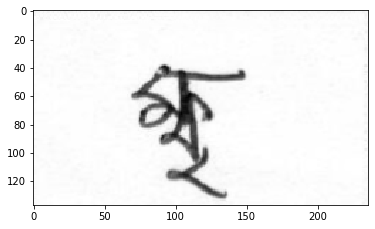

In [5]:
sample = train_ds[0]
print(sample)
plt.imshow(sample['image'], cmap='gray')

## Augmentation

In [5]:
def plot_augmented_images(dataset, aug_dict, ncols=6):
    nrows = len(aug_dict)

    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 2 * nrows))

    for i, (name, aug) in enumerate(aug_dict.items()):
        for j in range(ncols):
            ax = axes[i, j]
            if j == 0:
                ax.text(0.5,
                        0.5,
                        name,
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=15)
                ax.axis('off')
            else:
                sample = dataset[j - 1]
                image = sample['image']
                label = sample['label']

                if aug is not None:
                    image = aug(image=image)['image']
                ax.imshow(image, cmap='gray')
                ax.set_title(f'label: {label}')

    plt.tight_layout()

### Blur

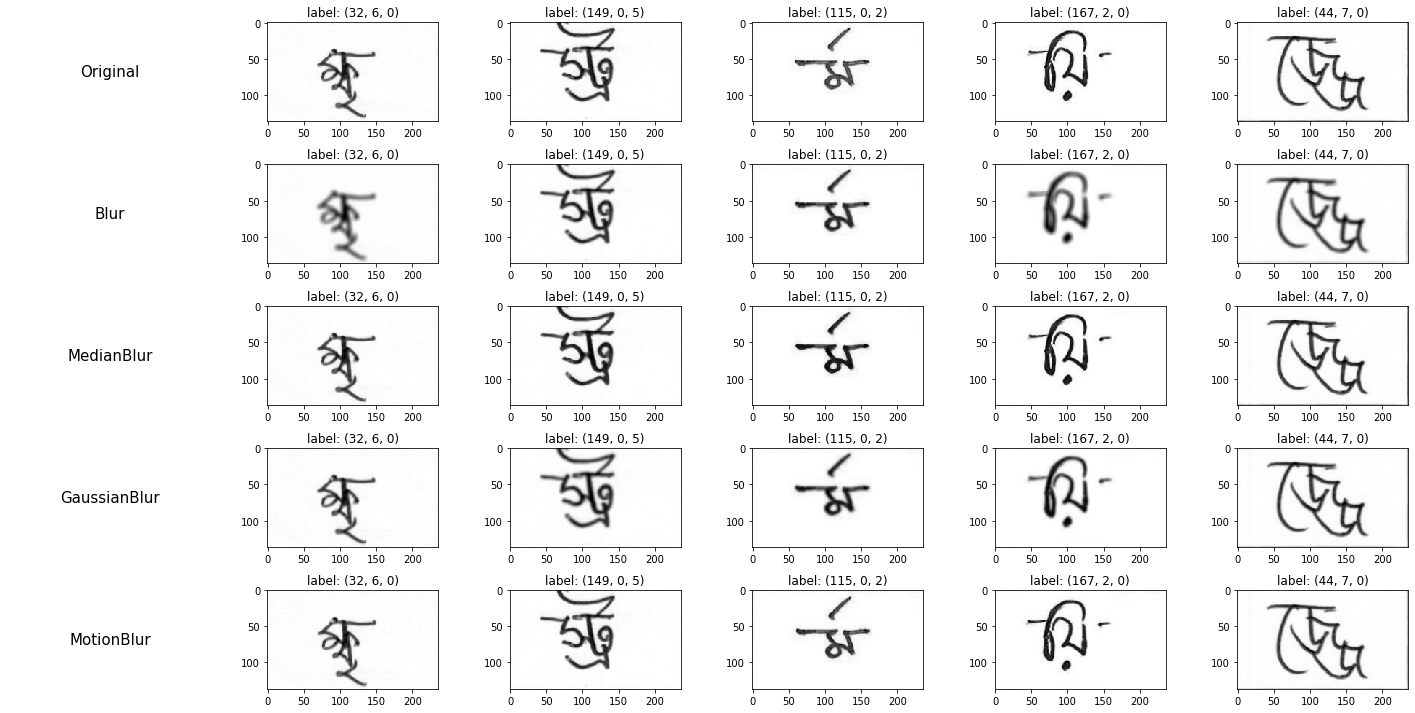

In [9]:
aug_dict = {
    'Original': None,
    'Blur': albumentations.Blur(p=1.0),
    'MedianBlur': albumentations.MedianBlur(blur_limit=5, p=1.0),
    'GaussianBlur': albumentations.GaussianBlur(p=1.0),
    'MotionBlur': albumentations.MotionBlur(p=1.0)
}

plot_augmented_images(train_ds, aug_dict)

### Noise

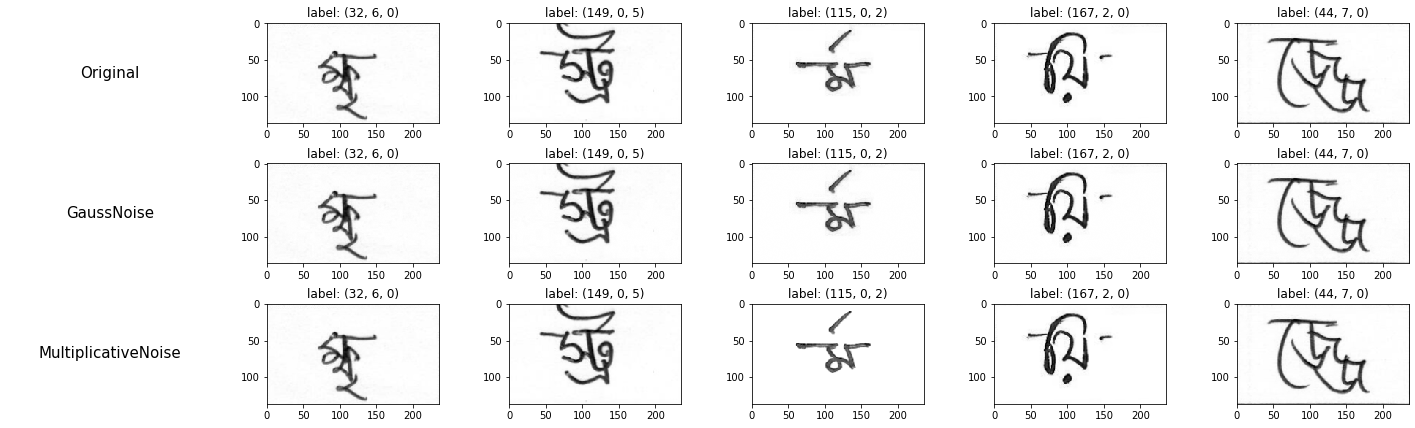

In [11]:
aug_dict = {
    'Original': None,
    'GaussNoise': albumentations.GaussNoise(var_limit=5 / 255, p=1.0),
    'MultiplicativeNoise': albumentations.MultiplicativeNoise(p=1.0)
}

plot_augmented_images(train_ds, aug_dict)

### Cutout

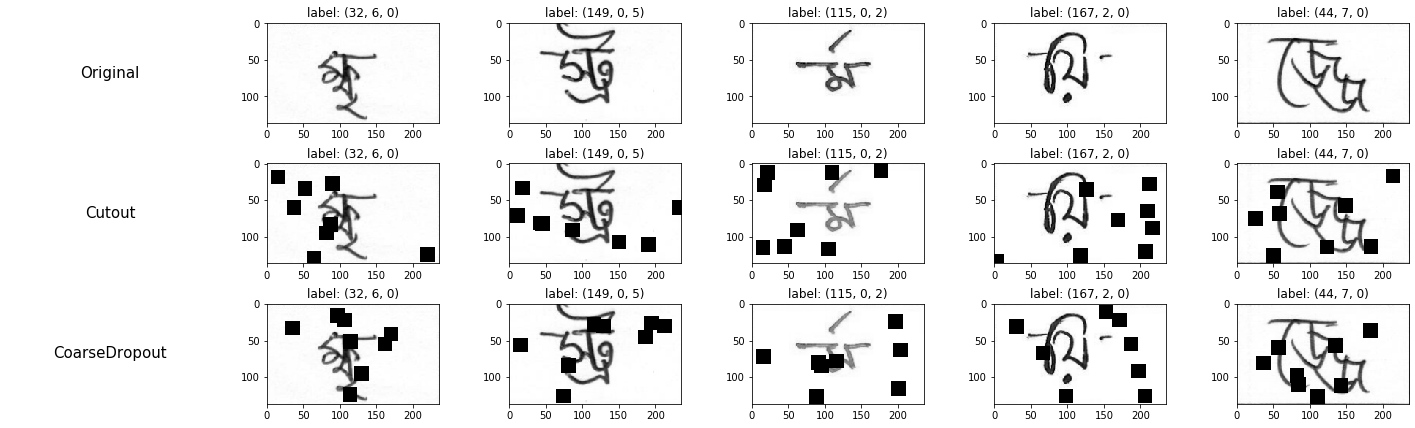

In [13]:
aug_dict = {
    'Original':
    None,

    # CoarseDropout of square regions in the image
    'Cutout':
    albumentations.Cutout(num_holes=8, max_h_size=20, max_w_size=20, p=1.0),

    # CoarseDropout of rectangular regions in the image
    'CoarseDropout':
    albumentations.CoarseDropout(max_holes=8,
                                 max_height=20,
                                 max_width=20,
                                 p=1.0)
}

plot_augmented_images(train_ds, aug_dict)

### Distortion

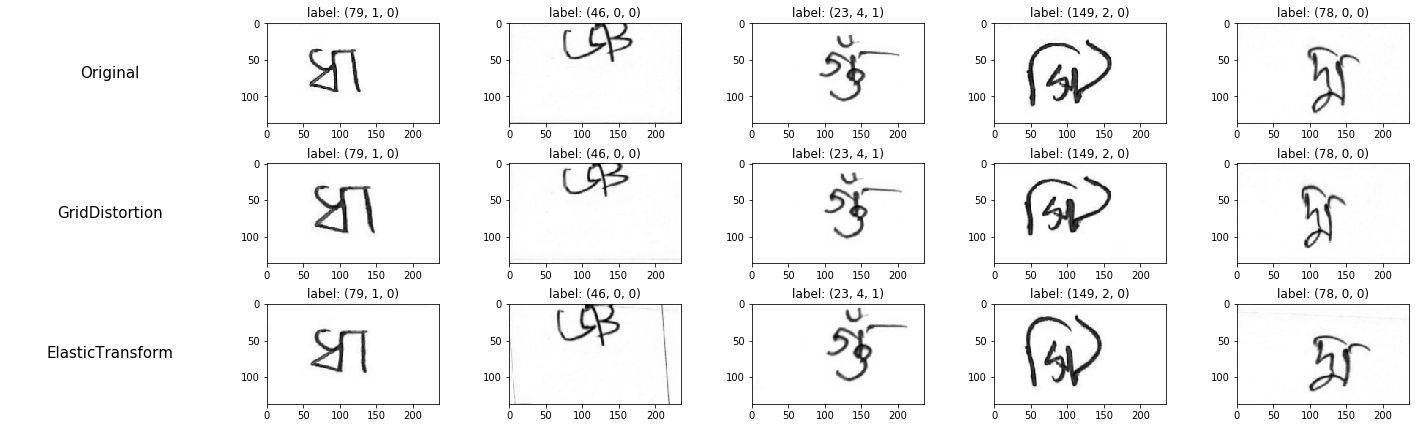

In [6]:
aug_dict = {
    'Original':
    None,
    'GridDistortion':
    albumentations.GridDistortion(p=1.0),
    'ElasticTransform':
    albumentations.ElasticTransform(sigma=50, alpha=1, alpha_affine=10, p=1.0)
}

plot_augmented_images(train_ds, aug_dict)

### Brightness, contrast related methods

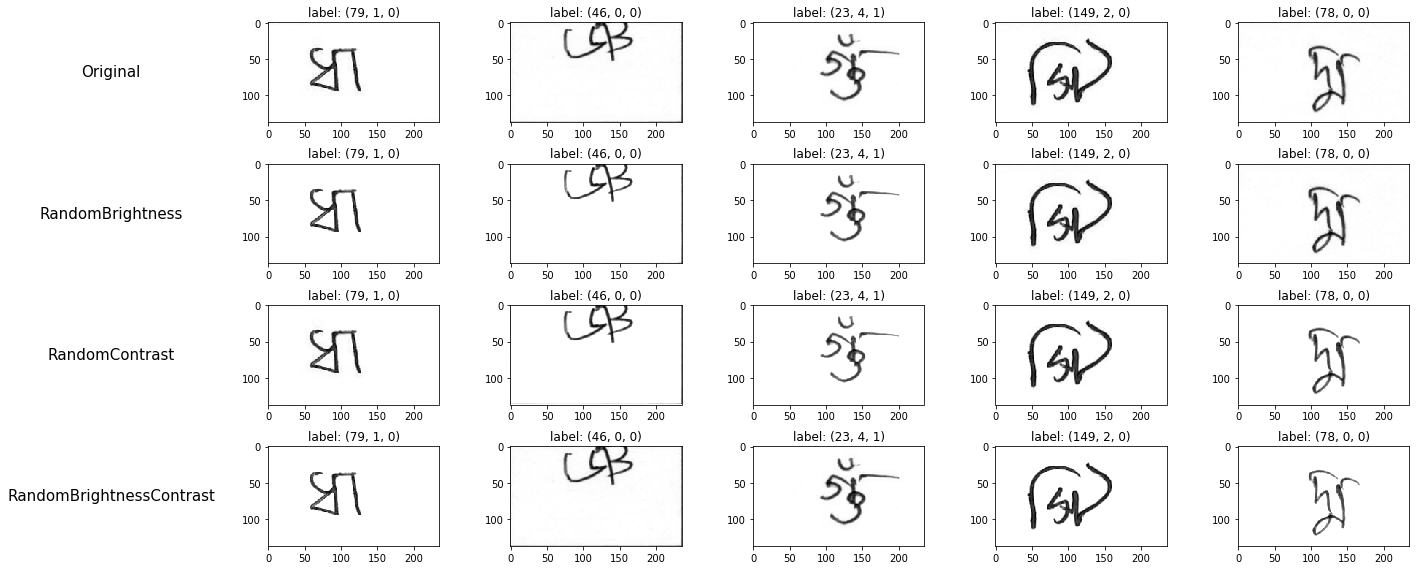

In [7]:
aug_dict = {
    'Original': None,
    'RandomBrightness': albumentations.RandomBrightness(p=1.0),
    'RandomContrast': albumentations.RandomContrast(p=1.0),
    'RandomBrightnessContrast': albumentations.RandomBrightnessContrast(p=1.0)
}

plot_augmented_images(train_ds, aug_dict)

### Affine related methods

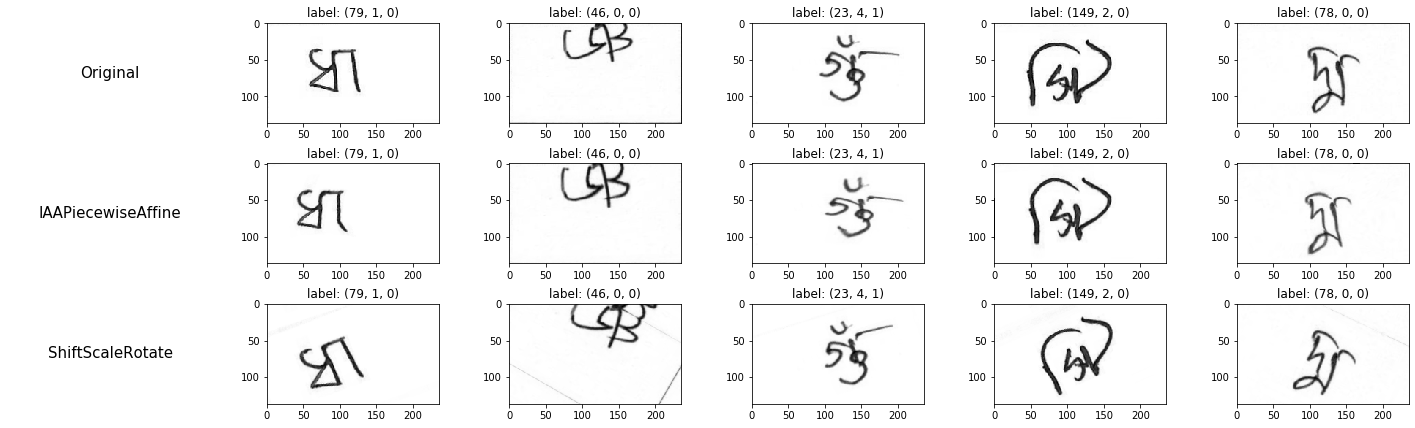

In [9]:
aug_dict = {
    'Original': None,
    'IAAPiecewiseAffine': albumentations.IAAPiecewiseAffine(p=1.0),
    'ShiftScaleRotate': albumentations.ShiftScaleRotate(
        shift_limit=0.0625,
        scale_limit=0.1,
        rotate_limit=30,
        p=1.0)
}

plot_augmented_images(train_ds, aug_dict)